## Libraries and data import

In [1]:
# Imports
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import numpy
import math
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, merge
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
import keras.backend as K
from natsort import natsorted, ns
import keras
import PIL
from keras.regularizers import l2
from glob import glob
from keras.applications import vgg16, xception
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, LearningRateScheduler
from matplotlib import pyplot
import tensorflow as tf
from sklearn.model_selection import train_test_split

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

Using TensorFlow backend.


In [2]:
# Data path
data = "../../coral_img/"

# Train and test directories
train_dir = data + "train/"
test_dir = data + "Test_Mixed/"

## Seeds and model parameters

In [3]:
# Fijar las semillas
seed = 2032 # Semilla del numpy
tf.set_random_seed(seed) # Fijar semilla del keras/tensorflow

epochs = 500
batch_size = 32

model_name = 'model.h5'

## Brightness fix through YCrCb color space

In [4]:
def brightness_fix(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_YCrCb = cv2.cvtColor(img_RGB, cv2.COLOR_RGB2YCrCb)
    
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
    cl1 = clahe.apply(img_YCrCb[:,:,0])
    
    img_YCrCb[:,:,0] = cl1         
    img_RGB_2 = cv2.cvtColor(img_YCrCb, cv2.COLOR_YCrCb2RGB)
    
    img_blur = cv2.GaussianBlur(img_RGB_2, (5, 5), 0)
    
    return img_blur

## Data import and normalization

In [5]:
# Classes
clases = sorted(os.listdir(train_dir))

# Train data import
x_train = np.array([brightness_fix(cv2.imread(os.path.join(train_dir, cl, name), cv2.IMREAD_COLOR)) for cl in clases
           for name in os.listdir(os.path.join(train_dir, cl))])
y_lab = np.array([n for n, cl in enumerate(clases)
           for name in os.listdir(os.path.join(train_dir, cl))])

# Train data shuffle
idx = np.random.permutation(len(x_train))
x_train, y_lab = x_train[idx], y_lab[idx]

# One hot encoding
y_train = to_categorical(y_lab, dtype=int)

# Train and validation set
#x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,stratify=y_train,test_size=0.2, random_state = 69)

# Test data import
test_files = natsorted(os.listdir(test_dir))
x_test = np.array([brightness_fix(cv2.imread(os.path.join(test_dir, name), cv2.IMREAD_COLOR)) for name in test_files])

## Data augmentation

In [6]:
# Data generator
datagen = ImageDataGenerator(
    rotation_range=1,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zoom_range=0.3,
    horizontal_flip=True,
    validation_split=0.2,
)

# Validation and test set normalization
datagen.fit(x_train)

#x_validation = (x_validation - datagen.mean)/(datagen.std + 0.000001)
x_test = (x_test - datagen.mean)/(datagen.std + 0.000001)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


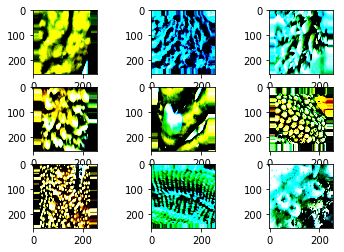

In [7]:
for X_batch, y_batch in datagen.flow(x_train, y_train):
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i])
    pyplot.show()
    break

## Load model

In [8]:
# create the base pre-trained model
base_model = xception.Xception(weights='imagenet',include_top=False, input_shape=(256,256,3))


#base_model = Model(inputs=base_model.input, outputs=base_model.get_layer('activation_40').output)


base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
_____________________________________

## Add transfer learning layers

In [9]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dropout(rate=0.25)(x)
x=Dense(1024, activation='relu')(x)
x=Dropout(rate=0.25)(x)
x=Dense(512,activation='relu')(x) 
preds=Dense(14,activation='softmax')(x) 

model=Model(inputs=base_model.input, outputs=preds)

for i,layer in enumerate(model.layers):
    print(i,layer.name)
    
for layer in base_model.layers:
    layer.trainable=False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 blo

In [10]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False
        
for layer in model.layers[129:]:
    layer.trainable=True

In [11]:
# compile the model (should be done *after* setting layers to non-trainable)
learning_rate = 0
decay_rate = 0
momentum = 0.9

opt_SGD = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
opt_Adam = Adam(lr=0) 

model.compile(loss='categorical_crossentropy', optimizer=opt_Adam,metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Run model

In [12]:
early_stopping_callback = EarlyStopping(monitor='val_loss', mode='min', min_delta=0, patience=10, restore_best_weights = True)

def step_decay(epoch):
    if epoch < 30:
        epochs_drop = 30.0
    else:
        epochs_drop = 10.0
    initial_lrate = 0.00005
    drop = 0.5
    
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate

step_decay_callback = LearningRateScheduler(step_decay)

callback_list = [early_stopping_callback, step_decay_callback]

# fits the model on batches with real-time data augmentation:
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
#                   steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
#                   validation_data = (x_validation, y_validation),
#                   validation_steps = len(x_validation) / batch_size,
#                   verbose=1, callbacks=callback_list)

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, subset="training"),
                   steps_per_epoch=int(len(x_train)*0.8) / batch_size, epochs=epochs,
                   validation_data = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation'),
                   validation_steps = int(len(x_train)*0.2) / batch_size,
                   verbose=1, callbacks=callback_list)

model.save(model_name)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
16/15 [==============================] - 12s 763ms/step - loss: 2.5810 - acc: 0.1188 - val_loss: 2.4748 - val_acc: 0.2500
Epoch 2/500
16/15 [==============================] - 4s 273ms/step - loss: 2.3870 - acc: 0.2598 - val_loss: 2.3101 - val_acc: 0.3629
Epoch 3/500
16/15 [==============================] - 4s 272ms/step - loss: 2.2570 - acc: 0.4002 - val_loss: 2.1357 - val_acc: 0.5161
Epoch 4/500
16/15 [==============================] - 4s 271ms/step - loss: 2.0633 - acc: 0.5059 - val_loss: 1.9340 - val_acc: 0.6452
Epoch 5/500
16/15 [==============================] - 4s 272ms/step - loss: 1.8800 - acc: 0.6052 - val_loss: 1.6546 - val_acc: 0.7097
Epoch 6/500
16/15 [==============================] - 4s 272ms/step - loss: 1.6515 - acc: 0.6817 - val_loss: 1.4131 - val_acc: 0.7177
Epoch 7/500
16/15 [==============================] - 4s 273ms/step - loss: 1.4012 - acc: 0.7166 - val_loss: 1.1792 - val_acc: 0.7742
Epoch 8/500
16/15 [=

In [13]:

predictions_test = model.predict(x_test, verbose=1)

data = pd.DataFrame()
data['Id'] = test_files
data['Category'] = predictions_test.argmax(axis=-1)


data.to_csv("envio.csv", index=False)

146/146 [==============================] - 1s 10ms/step


In [14]:
conversion = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13
}
classes = []
for t in test_files:
    class_ = t.split("T")[0]
    classes.append(conversion[class_])

from sklearn.metrics import accuracy_score
print(accuracy_score(classes, data['Category']))

0.952054794520548
